- get rain data and visualise for overview <font color='orange'>&#9728;</font>
- cut and split data to reasonable train, val, test sets <font color='orange'>&#9728;</font>
- set up first generator and discriminator and overfit, play around with it, get first results (_November/December_)
- train on small training set and improve losses, accuracy, results (_December_)
- experiment with temporal discriminator (_December/January_)
- experiment with wind data (_January_)

## Imports and settings

In [1]:
import src

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from os import *
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')

In [3]:
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "-1" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10760108046203952612
]


______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.

In [10]:
inputs = src.get_data(sys.path[0]+"/rain")

[27/744]


KeyboardInterrupt: 

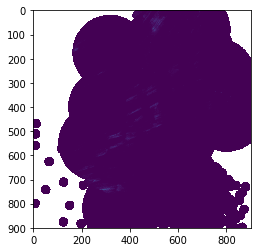

In [9]:
plt.imshow(np.ma.masked_where(inputs[0] <0,inputs[0]))

In [5]:
images = src.generate_datasets(inputs, n=10000, size=128, length=2, normalize=True, split=(6,2,2))

Shape of data: (10000, 2, 64, 64)

Training set: (6000, 2, 64, 64)
Validation set: (2000, 2, 64, 64)
Test set: (2000, 2, 64, 64)


In [5]:
images = np.load(sys.path[0]+"/dataset.npy").item()

In [6]:
#low_res_train = images["low_res_train"]
#low_res_xval = images["low_res_xval"]
#low_res_test = images["low_res_test"]
#overfit = np.reshape(images['images'],np.shape(images['images'])+(1,))
train = np.reshape(images["train"],np.shape(images["train"])+(1,))
xval = np.reshape(images["xval"],np.shape(images["xval"])+(1,))
test = np.reshape(images["test"],np.shape(images["test"])+(1,))
print(f"Training data: {train.shape}\nValidation data: {xval.shape}\nTest data: {test.shape}")

Training data: (6000, 2, 64, 64, 1)
Validation data: (2000, 2, 64, 64, 1)
Test data: (2000, 2, 64, 64, 1)


In [19]:
unet_train     = np.reshape(train[:,0,:,:,:],((train.shape[0],)+train.shape[2:]))
unet_truth     = np.reshape(train[:,1,:,:,:],((train.shape[0],)+train.shape[2:]))
unet_val       = np.reshape(xval[:,0,:,:,:],((xval.shape[0],)+xval.shape[2:]))
unet_val_truth = np.reshape(xval[:,1,:,:,:],((xval.shape[0],)+xval.shape[2:]))
print(unet_train.shape,"\n",unet_truth.shape,"\n",unet_val.shape,"\n",unet_truth.shape)
unet_test      = np.reshape(test[:,0,:,:,:],((test.shape[0],)+test.shape[2:]))
unet_test_truth = np.reshape(test[:,1,:,:,:],((test.shape[0],)+test.shape[2:]))

(6000, 64, 64, 1) 
 (6000, 64, 64, 1) 
 (2000, 64, 64, 1) 
 (6000, 64, 64, 1)


In [ ]:
overfit_train = np.reshape(train[5,0,:,:,:],((1,)+train.shape[2:]))
overfit_truth = np.reshape(train[5,1,:,:,:],((1,)+train.shape[2:]))

In [ ]:
%matplotlib inline
src.visualise_data(xval[:,:,:,:,0])

## U-net

In [27]:
model2=keras.Sequential()

init = keras.layers.Input(shape=(64,64,1))
ConvDown1  = keras.layers.Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding="same")(init)
Lr1 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown1)
#64
ConvDown2  = keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2),padding="same")(Lr1)
Lr2 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown2)
#32
ConvDown3  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr2)
Lr3 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown3)
#16
ConvDown4  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr3)
Lr4 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown4)
#8
ConvDown5  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr4)
Lr5 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown5)
#4

UpSamp1 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr5)
#8
merge1  = keras.layers.concatenate([ConvDown4,UpSamp1],axis=-1)#(UpSamp1)
Conv1   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge1)
Lr6 = keras.layers.LeakyReLU(alpha=0.0)(Conv1)
#8
UpSamp2 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr6)
#16
merge2  = keras.layers.concatenate([ConvDown3,UpSamp2],axis=-1)#(UpSamp2)
Conv2   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge2)
Lr7  = keras.layers.LeakyReLU(alpha=0.0)(Conv2)
#16
UpSamp3 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr7)

#32
Conv3   = keras.layers.Conv2D(filters=16,kernel_size=(4,4),strides=(1,1),padding="same")(UpSamp3)
Lr8  = keras.layers.LeakyReLU(alpha=0.0)(Conv3)

UpSamp4 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr8)
#64
Conv4   = keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'relu')(UpSamp4)

Conv5   = keras.layers.Conv2D(filters=1,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'elu')(Conv4)

model2 = keras.models.Model(inputs=init, outputs=Conv5)
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 64, 64, 8)    40          input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_51 (LeakyReLU)      (None, 64, 64, 8)    0           conv2d_61[0][0]                  
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 32, 32, 16)   528         leaky_re_lu_51[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [28]:
#train the model
model2.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss='mean_squared_error', metrics=[src.relative_error_tensor]) 
model2.fit(unet_train,
          unet_truth,
          batch_size = 100,
          epochs=50,
          validation_data=(unet_val,unet_val_truth),
          shuffle = True)

Tensor("metrics_6/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("conv2d_70_target:0", shape=(?, ?, ?, ?), dtype=float32)
Train on 6000 samples, validate on 2000 samples
Epoch 1/50
6000/6000 [==============================] - 140s 23ms/step - loss: 0.0303 - relative_error_tensor: 0.9583 - val_loss: 0.0274 - val_relative_error_tensor: 0.9539
Epoch 2/50
6000/6000 [==============================] - 150s 25ms/step - loss: 0.0260 - relative_error_tensor: 0.9447 - val_loss: 0.0266 - val_relative_error_tensor: 0.9456
Epoch 3/50
6000/6000 [==============================] - 165s 27ms/step - loss: 0.0252 - relative_error_tensor: 0.9368 - val_loss: 0.0260 - val_relative_error_tensor: 0.9198
Epoch 4/50
6000/6000 [==============================] - 161s 27ms/step - loss: 0.0246 - relative_error_tensor: 0.9310 - val_loss: 0.0254 - val_relative_error_tensor: 0.9227
Epoch 5/50
6000/6000 [==============================] - 182s 30ms/step - loss: 0.0244 - relative_error_tensor: 0.9264 -

6000/6000 [==============================] - 171s 29ms/step - loss: 0.0227 - relative_error_tensor: 0.8854 - val_loss: 0.0240 - val_relative_error_tensor: 0.9094
Epoch 48/50
6000/6000 [==============================] - 169s 28ms/step - loss: 0.0226 - relative_error_tensor: 0.8843 - val_loss: 0.0241 - val_relative_error_tensor: 0.8884
Epoch 49/50
6000/6000 [==============================] - 176s 29ms/step - loss: 0.0226 - relative_error_tensor: 0.8833 - val_loss: 0.0243 - val_relative_error_tensor: 0.9348
Epoch 50/50
6000/6000 [==============================] - 169s 28ms/step - loss: 0.0226 - relative_error_tensor: 0.8861 - val_loss: 0.0241 - val_relative_error_tensor: 0.8799


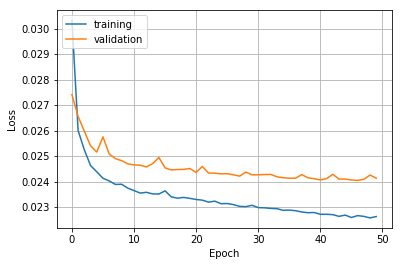

In [29]:
hist = model2.history
hist.history.keys()
plt.plot(hist.history['loss'],)
plt.plot(hist.history['val_loss'])
plt.grid()
plt.legend(['training', 'validation'], loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.yscale("log")
plt.savefig('training.png')

In [31]:
#test
predictions = model2.predict(unet_test, batch_size=100)
truth       = unet_test_truth
truth.shape

(2000, 64, 64, 1)

In [32]:
args = src.arg_getter(truth, predictions)
args[-1]

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:198: RuntimeWarning: divide by zero encountered in true_divide
  images[i, :, :, :] = np.divide(num, den)


741

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:198: RuntimeWarning: divide by zero encountered in true_divide
  images[i, :, :, :] = np.divide(num, den)


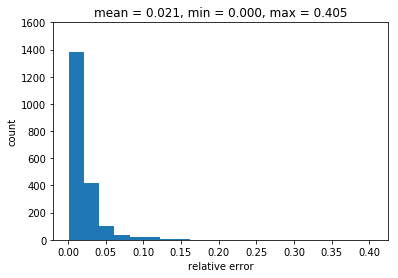

In [33]:
error_images, error_vals, error_means = src.error_distribution(truth,predictions, metric="relative_error")

In [40]:
error_images.shape

(2000, 64, 64, 1)

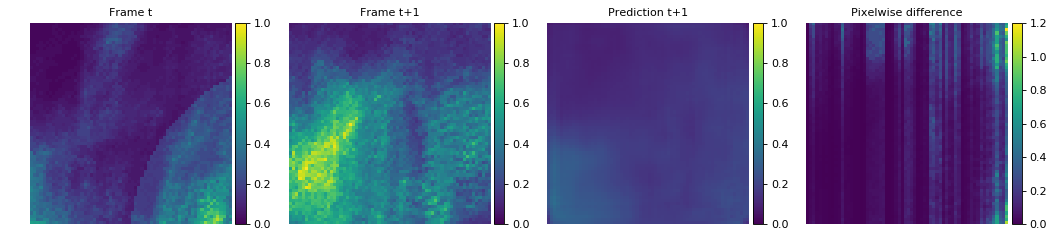

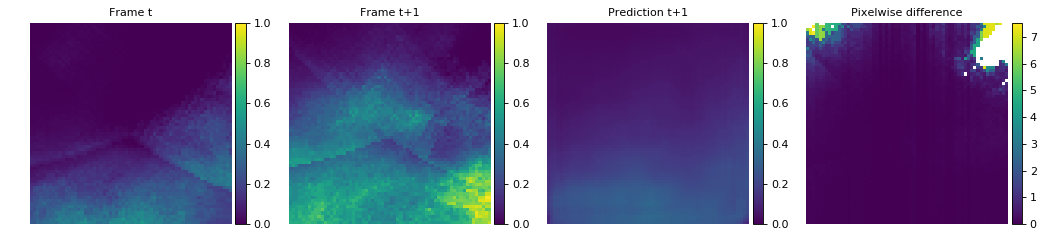

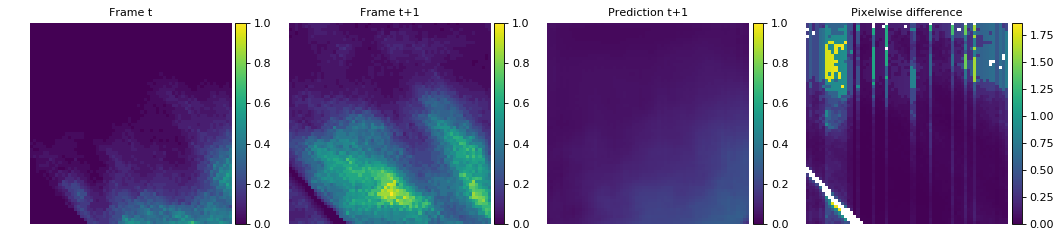

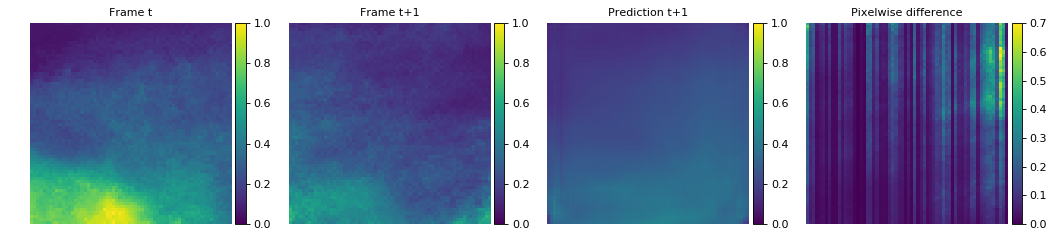

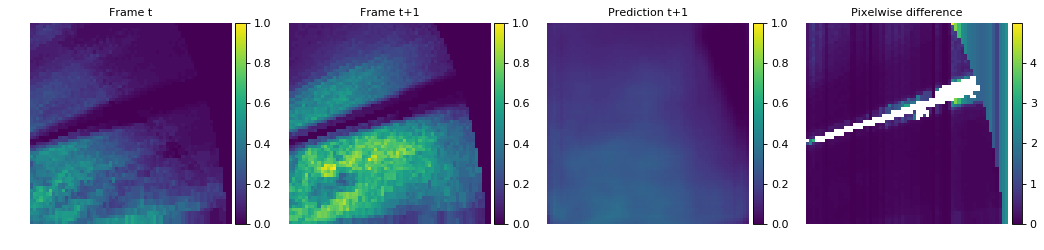

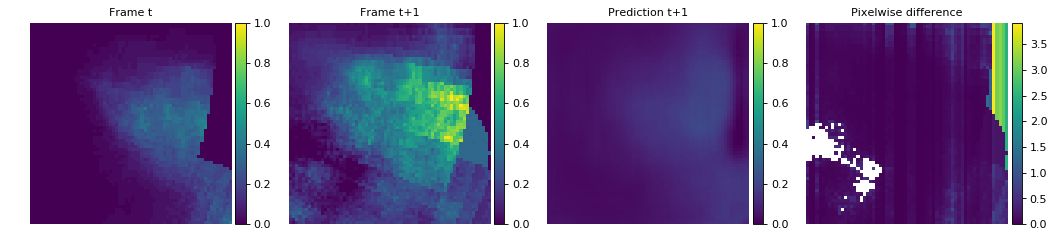

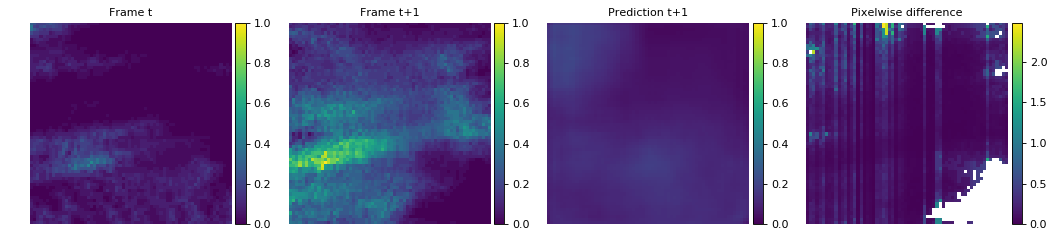

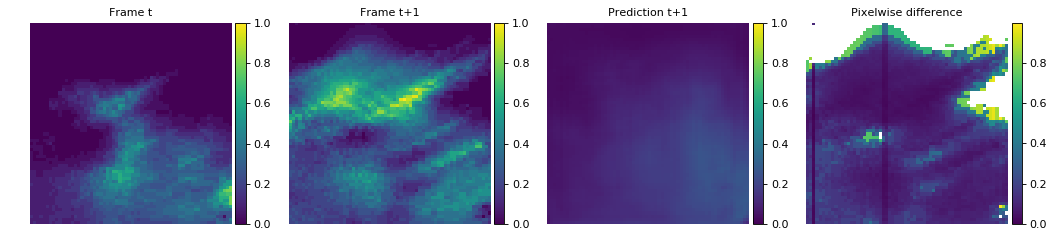

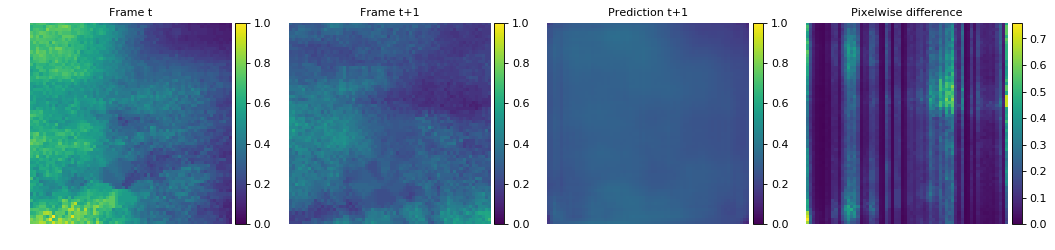

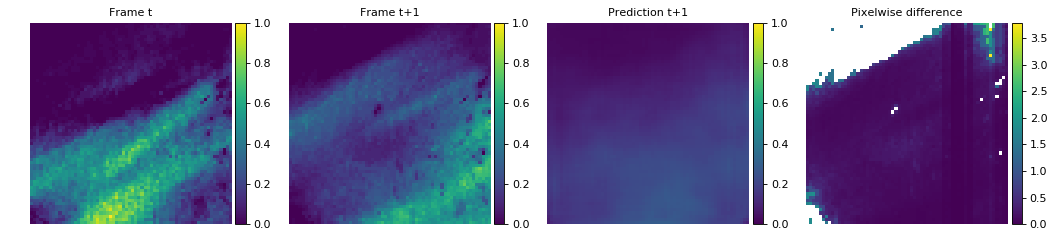

In [55]:
result_plotter(args[:10], (unet_test[:,:,:,0], truth[:,:,:,0], predictions[:,:,:,0], error_images[:,:,:,0]))

In [54]:
def result_plotter(indices, datasets, task='prediction'):

    if task == 'prediction':
        title = ['Frame t', 'Frame t+1', 'Prediction t+1', 'Pixelwise difference']
    elif task == 'upsampling':
        title = ['Original', 'Downsampled', 'Upsampled', 'Pixelwise difference']
    else:
        sys.exit("Task must be 'prediction' or 'upsampling'.")
    for i in indices:
        fig, axes = plt.subplots(nrows=1, ncols=4, num=None, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
        for j, ax in enumerate(axes.flat):
            im = ax.imshow(datasets[j][int(i)], vmin=0,
                           vmax=max([np.max(dset[int(i)]) for dset in datasets[:2]]) if int(j) < 3 else None)
                           #, norm=colors.PowerNorm(gamma=0.5) if int(j) == 3 else None)
            ax.set_title(f"{title[j]}", fontsize=10)
            colorbar(im)
            ax.axis('off')
        plt.savefig(f"Sample_{i}.png")
    plt.show()
    
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)
